In [5]:
import pandas as pd

# Read and preparing Data

In [6]:
data_series = pd.read_csv("/workspaces/BiciMad_4geeks_ML/data/interim/bicimad_time_series.csv", sep=',')

In [7]:
data_series['unlock_date'] = pd.to_datetime(data_series['unlock_date'], format='%Y-%m-%d')

In [8]:
data_series = data_series.set_index(data_series['unlock_date'])

# Time Series

Evaluareamos y predecidermos según cada dato de nuestro data_series, teniendo como índice la fecha de desbloqueo 'unlock_date'. Despues de estudiar y valorar todas las opciones univariantes y multivariantes como: Prophet, XGboost,SVR,... nos quedamos con los modelos que pueden predecir mejor y ser mas eficaces por nuestro conjunto de datos: ***LSTM (multivariante)*** y ***ARIMA (univariante)*** 

# LSTM

In [9]:
import numpy as np 
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from statsmodels.tools.eval_measures import rmse 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 
from keras.models import load_model
import warnings; 
warnings.simplefilter('ignore') 
from pickle import dump

2024-02-05 19:03:57.591352: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 19:03:59.761362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 19:03:59.761460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 19:04:00.115259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 19:04:00.825533: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 19:04:00.827500: I tensorflow/core/platform/cpu_feature_guard.cc:1

* Trip_minutes

In [10]:
data_series_LSTM = data_series.drop(columns=['idDriver', 'idBike',  'fleet', 
       'unlock_hour', 'latitude_unlock', 'longitude_unlock', 'station_unlock',
       'dock_unlock',  'lock_date', 'lock_hour',
       'latitude_lock', 'longitude_lock', 'station_lock', 'dock_lock', 'trip_day_of_week',
       'trip_duration_category', 'station_unlock_count', 'station_lock_count',
       'travel_direction', 'idDriver_n', 'unlock_station_name_n',
       'lock_station_name_n', 'lock_station_name', 'unlock_station_name'])

In [11]:
data_series_LSTM = data_series_LSTM.set_index(data_series_LSTM['unlock_date'])

In [61]:
#Dividimos en train y test manualmente al ser una serie temporal
X_train_min = data_series_LSTM[data_series_LSTM['unlock_date'] < '2022-10-01'].drop(columns=['unlock_date', 'trip_minutes'])
y_train_min = data_series_LSTM[data_series_LSTM['unlock_date'] < '2022-10-01']['trip_minutes']
X_test_min = data_series_LSTM[data_series_LSTM['unlock_date'] >= '2022-10-01'].drop(columns=['unlock_date', 'trip_minutes'])
y_test_min = data_series_LSTM[data_series_LSTM['unlock_date'] >= '2022-10-01']['trip_minutes']

In [62]:
# Crear el modelo
model_LSTM_min = Sequential()

# Agregar capas al modelo
model_LSTM_min.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 1)))
model_LSTM_min.add(Dropout(0.2))
model_LSTM_min.add(LSTM(50, return_sequences=False))
model_LSTM_min.add(Dropout(0.2))
model_LSTM_min.add(Dense(25))
model_LSTM_min.add(Dense(1))

In [76]:
# Crear la instancia de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# Compilar el modelo
model_LSTM_min.compile(optimizer='adam', loss='mean_squared_error')
# Entrenar el modelo
history = model_LSTM_min.fit(X_train_min, y_train_min, epochs=100, batch_size=64, validation_split=0.5, callbacks=[early_stopping], verbose=0)

In [77]:
# Evaluar el modelo
train_loss = model_LSTM_min.evaluate(X_train_min, y_train_min, verbose=0)
test_loss = model_LSTM_min.evaluate(X_test_min, y_test_min, verbose=0)

print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')

Train Loss: 3.308763265609741, Test Loss: 3.6069865226745605


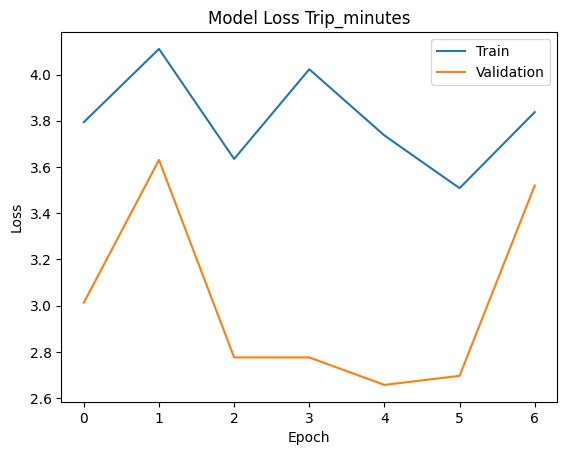

In [78]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Trip_minutes')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [18]:
# Guardar el modelo
model_LSTM_min.save('model_LSTM_min.h5')

In [83]:
data_series_min = data_series_LSTM.groupby(data_series_LSTM.index.month).mean()

In [84]:
def multi_step_forecast(model, input_data, num_steps):
    x = input_data
    forecasts = []
    for _ in range(num_steps):
        yhat = model.predict(np.array([x]))[0, :] # Realiza la predicción
        forecasts.append(yhat) # Guarda la predicción
        x = np.roll(x, -1) # Desplaza la secuencia hacia adelante
        x[-1] = yhat # Añade la nueva predicción al final
    return np.array(forecasts)

# Suponiendo que 'model_LSTM_dis' ya está entrenado y 'X_last_12_months' contiene los datos de entrada
forecast = multi_step_forecast(model_LSTM_min, data_series_min['trip_minutes'], 12) # Predice los próximos 12 meses


1/1 [==============================] - 0s 17ms/step


In [89]:
forecast

array([[28.494883],
       [39.68266 ],
       [42.540115],
       [42.155167],
       [42.2041  ],
       [42.56357 ],
       [42.695602],
       [42.723194],
       [42.71537 ],
       [42.646706],
       [42.587852],
       [42.71291 ]], dtype=float32)

In [37]:
forecast

array([[29.644434],
       [27.268692],
       [43.33868 ],
       [43.801174],
       [45.23557 ],
       [45.36893 ],
       [45.470383],
       [45.497208],
       [45.511284],
       [38.219864],
       [45.199673],
       [45.161716]], dtype=float32)

* Distance

In [19]:
data_series_LSTM_dis = data_series.drop(columns=['idDriver', 'idBike',  'fleet', 
       'unlock_hour', 'station_unlock',
       'dock_unlock', 'lock_date', 'lock_hour',
       'latitude_lock', 'dock_lock', 'trip_day_of_week',
       'trip_duration_category', 'station_unlock_count', 'station_lock_count',
       'travel_direction', 'idDriver_n', 'unlock_station_name_n',
       'lock_station_name_n', 'lock_station_name', 'unlock_station_name'])

In [20]:
data_series_LSTM_dis = data_series_LSTM_dis.set_index(data_series_LSTM_dis['unlock_date'])

In [21]:
data_series_LSTM_dis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30001 entries, 2022-01-01 to 2022-12-31
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   trip_minutes              30001 non-null  float64       
 1   unlock_date               30001 non-null  datetime64[ns]
 2   latitude_unlock           30001 non-null  float64       
 3   longitude_unlock          30001 non-null  float64       
 4   longitude_lock            30001 non-null  float64       
 5   station_lock              30001 non-null  int64         
 6   distance                  30001 non-null  float64       
 7   trip_speed                30001 non-null  float64       
 8   trip_day_of_week_n        30001 non-null  int64         
 9   trip_duration_category_n  30001 non-null  int64         
 10  travel_direction_n        30001 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 2.7 MB

In [22]:
#Dividimos en train y test manualmente al ser una serie temporal
X_train_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] < '2022-10-01'].drop(columns=['unlock_date', 'distance'])
y_train_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] < '2022-10-01']['distance']
X_test_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] >= '2022-10-01'].drop(columns=['unlock_date', 'distance'])
y_test_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] >= '2022-10-01']['distance']

In [23]:
# Crear el modelo
model_LSTM_dis = Sequential()

# Agregar capas al modelo
model_LSTM_dis.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 1)))
model_LSTM_dis.add(Dropout(0.2))
model_LSTM_dis.add(LSTM(50, return_sequences=False))
model_LSTM_dis.add(Dropout(0.2))
model_LSTM_dis.add(Dense(25))
model_LSTM_dis.add(Dense(1))

In [24]:
# Crear la instancia de EarlyStopping
early_stopping_dis = EarlyStopping(monitor='val_loss', patience=2)
# Compilar el modelo
model_LSTM_dis.compile(optimizer='adam', loss='mean_squared_error')
# Entrenar el modelo
history_dis = model_LSTM_dis.fit(X_train_dis, y_train_dis, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping_dis], verbose=0)

In [25]:
# Evaluar el modelo
train_loss_dis = model_LSTM_dis.evaluate(X_train_dis, y_train_dis, verbose=0)
test_loss_dis = model_LSTM_dis.evaluate(X_test_dis, y_test_dis, verbose=0)

print(f'Train Loss: {train_loss_dis}, Test Loss: {test_loss_dis}')

Train Loss: 0.05194377899169922, Test Loss: 0.053491730242967606


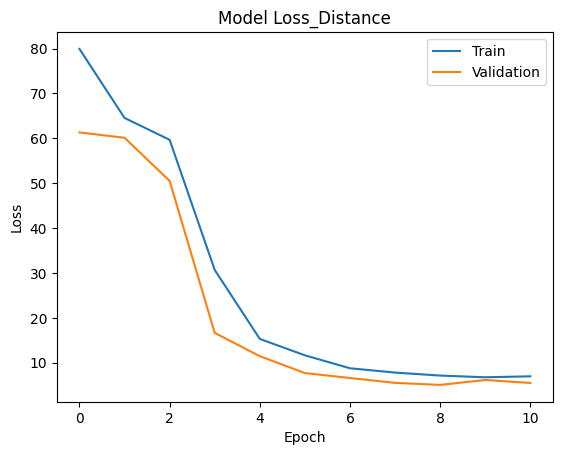

In [57]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history_dis.history['loss'])
plt.plot(history_dis.history['val_loss'])
plt.title('Model Loss_Distance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [26]:
# Guardar el modelo
model_LSTM_dis.save('model_LSTM_dis.h5')

In [28]:
data_series_LSTM_dis['distance']

unlock_date
2022-01-01    4.112001
2022-01-01    0.000000
2022-01-01    3.507072
2022-01-01    0.000000
2022-01-01    1.919471
                ...   
2022-12-31    1.720977
2022-12-31    4.108584
2022-12-31    0.889809
2022-12-31    0.404181
2022-12-31    4.942072
Name: distance, Length: 30001, dtype: float64

In [31]:
import numpy as np

def multi_step_forecast(model, input_data, num_steps):
    x = input_data
    forecasts = []
    for _ in range(num_steps):
        yhat = model.predict(np.array([x]))[0, :] # Realiza la predicción
        forecasts.append(yhat) # Guarda la predicción
        x = np.roll(x, -1) # Desplaza la secuencia hacia adelante
        x[-1] = yhat # Añade la nueva predicción al final
    return np.array(forecasts)

# Suponiendo que 'model_LSTM_dis' ya está entrenado y 'X_last_12_months' contiene los datos de entrada
forecast = multi_step_forecast(model_LSTM_dis, data_series_LSTM_dis['distance'], 1) # Predice los próximos 12 meses


1/1 [==============================] - 2s 2s/step


In [32]:
forecast

array([[11.643635]], dtype=float32)